### Coding Agent
结合思维链和code interpreter,可以让大模型构建非常复杂的代码。

拿到一个代码编写任务，我们可以让我们的Agent(expert_coding函数)首先构建编写代码的步骤，然后每次回答仅给出其中一个部分的代码，然后运行代码观察是否有问题，如果有问题则重新生成代码，直到运行成功，再进行下一步代码的撰写，直到最终所有的代码完成，就终止循环。

在我构建的这个Agent中，每次更新一部分代码，都会动态地添加到最终撰写的代码当中，然后每部分代码都会保存到本地的jupyter文档。
不仅如此，还有一个直接编写所有代码的小agent：direct_coding，可以在一次回答中给出比较优秀的代码。

未来可优化的地方：
- 每次输出代码后，再让Agent反思一次，提升代码质量
- 在最后，汇总所有的代码并整理得更美观


In [3]:
from datetime import datetime
from tools.llm_api import *
from tools.json_tool import *
from tools.code_interpreter import *
from tools.text2jupyter import text_to_jupyter
from IPython.display import clear_output
import matplotlib.pyplot as plt

# 获取提示词
def get_prompt(path):
    with open(path, 'r', encoding="utf-8") as file:
        prompt = file.read()
    return prompt
    
class CodingExpert:
    def __init__(self
                 , name="CodingExpert"
                 , model="glm-4"
                 , temperature=0.9
                 ):
        self.agent_name = name
        self.direct_coding_system_prompt = get_prompt("free_agent/prompts/coding_agent_prompt/direct_coding_system_prompt.txt")
        self.expert_coding_system_prompt = get_prompt("free_agent/prompts/coding_agent_prompt/expert_coding_system_prompt.txt")
        # 代码修改prompt 
        self.coding_correction_prompt = get_prompt("free_agent/prompts/coding_agent_prompt/coding_correction_prompt.txt")
        self.direct_conversations = [{"role": "system", "content": self.direct_coding_system_prompt}]
        self.coding_expert_conversations = [{"role": "system", "content": self.expert_coding_system_prompt}]
        # 代码保存地址
        self.code_save_path = "free_agent/coding_history"
        # 如果没有文件夹则创建
        if not os.path.exists(self.code_save_path):
            os.makedirs(self.code_save_path)
        self.model = model
        self.temperature = temperature 
        
        # 总聊天记录
        # self.total_conversations = []
        # total_system_prompt = get_prompt("free_agent/prompts/coding_agent_prompt/total_system_prompt.txt")
        # self.total_conversations.append({"role": "system", "content": total_system_prompt})
        
    def get_expert_answer_converse(self, coding_expert_conversations):
        ans = ""
        for char in get_llm_answer_converse(coding_expert_conversations, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        self.coding_expert_conversations.append({"role": "assistant", "content": ans})
        return ans
    
    def get_expert_answer(self, question):
        self.coding_expert_conversations.append({"role": "user", "content": question})
        ans = ""
        for char in get_llm_answer_converse(self.coding_expert_conversations, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        self.coding_expert_conversations.append({"role": "assistant", "content": ans})
        return ans
    
    # 反思: 优化代码
    
    # 创意 be creative
    
    # llm修改代码
    def modify_code(self, conversations, question, code, error):
        print("\n\n当前错误：", error + "\n\n")
        coding_correction_prompt = get_prompt("free_agent/prompts/coding_agent_prompt/coding_correction_prompt.txt")
        coding_correction_prompt = coding_correction_prompt.format(
            question=question
            , code=code
            , error=error
        )
        ans = ""
        conversations.append({"role": "user", "content": coding_correction_prompt})
        for char in get_llm_answer_converse(self.direct_conversations, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        code = extract_python_code(ans)
        conversations.append({"role": "assistant", "content": ans})
        return code
    
    def save_code(self, code):
        jupyter_code = "```python\n" + code + "\n```"
        date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        file_name = f"{self.code_save_path}/{date}"
        text_to_jupyter(jupyter_code, file_name)
    
    def auto_run_code(self, conversations, question, code):
        """
        运行单次代码
        """
        print("\n\n===正在运行代码===")
        self.save_code(code)
        result = run_code(code)
        run_message = "代码运行结果：\n" + "="*30 + f"\n{result}\n" + "="*30
        conversations.append({"role": "user", "content": run_message})
        print(run_message)
        max_try_num = 3
        try_num = 0
        while "代码执行出错" in result:
            print(f"\n\n===代码出错，第{try_num+1}次修改尝试===\n")
            if try_num >= max_try_num:
                break
            self.final_code = self.modify_code(conversations, question, self.final_code, result)
            conversations.append({"role": "assistant", "content": f"修改后的代码：\n{self.final_code}"})
            self.save_code(self.final_code)
            result = run_code(self.final_code)
            print("\n\n修改代码运行结果：\n" + "="*30 + f"\n{result}\n" + "="*30)
            try_num += 1
            time.sleep(3)
        if try_num == 0:
            print("\n\n代码运行成功！")
            self.temp_code = code
            print("增加至最终代码中")
        else:
            print(f"代码经过{try_num}次修改后成功运行！")
            
        return result
    
    def direct_coding(self, question, run_code=True):
        ans = ""
        self.direct_conversations.append({"role": "user", "content": question})
        for char in get_llm_answer_converse(self.direct_conversations, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        code = extract_python_code(ans)
        if run_code:
            result = self.auto_run_code(self.direct_conversations, question, code)
            return result
        else:
            return ans
    
    # 运行结果分析
    def run_code_analysis(self, result, conversations):
        """
        分析代码运行结果
        """
        ana_prompt = get_prompt("free_agent/prompts/coding_agent_prompt/run_code_analysis_prompt.txt")
        ana_prompt = ana_prompt.format(result=result)
        ans = ""
        conversations.append({"role": "user", "content": ana_prompt})
        for char in get_llm_answer_converse(self.direct_conversations, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
    
    def test_code_snipt(self):
        """
        测试代码片段
        """
        with open("free_agent/test_code.txt", 'r', encoding="utf-8") as file:
            code_snippet = file.read()
        return code_snippet
    
    def expert_coding(self, question, max_iter = 5):
        # 初始化图表
        plt.ion()  # 打开交互模式
        self.temp_code = ""
        """
        每次增加代码，测试是否正确，如果正确则加入原来的代码中，如果不正确则修改
        """
        self.final_code = ""
        question = question + "\n\n 注意，你每次回答只需要回答一部分内容，当我说继续的时候，你再进行下一步。"
        self.coding_expert_conversations.append({"role": "user", "content": question})
        iter = 0
        print("\n" + f"="*20 + f"代码链 - 第{iter + 1}次迭代" + "="*20)
        ans = self.get_expert_answer_converse(self.coding_expert_conversations)
        self.temp_code = extract_python_code(ans)
        
        self.auto_run_code(self.coding_expert_conversations, question, self.temp_code)
        self.final_code += self.temp_code
        while iter < max_iter:
            plt.clf()  # 清除当前图形
            if ans.find("[END]") == -1:
                print("\n" + f"="*20 + f"代码链 - 第{iter + 2}次迭代" + "="*20)
                self.coding_expert_conversations.append({"role": "user", "content": "继续"})
                ans = self.get_expert_answer_converse(self.coding_expert_conversations)
                self.temp_code = extract_python_code(ans)
                self.final_code += self.temp_code
                self.auto_run_code(self.coding_expert_conversations, question, self.final_code)
                # self.final_code += self.temp_code
                iter += 1    
            else:
                break
        return ans
        
        


====================代码链 - 第1次迭代====================
# Part 1: 虚拟数据的创建 

```python
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# 设置随机种子，保证结果可重复
random.seed(42)

# 创建虚拟的用户数据
# 用户ID范围在1到1000
user_data = {
    'user_id': range(1, 1001),
    'age': [random.randint(18, 65) for _ in range(1000)],
    'gender': [random.choice(['Male', 'Female']) for _ in range(1000)],
    'signup_date': [datetime.now() - timedelta(days=random.randint(1, 365)) for _ in range(1000)]
}
df_users = pd.DataFrame(user_data)

# 创建虚拟的商品数据
# 商品ID范围在1到1000
item_data = {
    'item_id': range(1, 1001),
    'category': [random.choice(['Electronics', 'Books', 'Clothing', 'Home & Kitchen']) for _ in range(1000)],
    'price': [round(random.uniform(5.0, 500.0), 2) for _ in range(1000)]
}
df_items = pd.DataFrame(item_data)

# 创建虚拟的用户行为数据
# 使用随机日期时间戳和随机用户ID、商品ID进行创建
behavior_data = {
    'user_id': [random.choice(df_users['user_id']) for _ in range(5000)],
    'item_id': [rando

<Figure size 640x480 with 0 Axes>

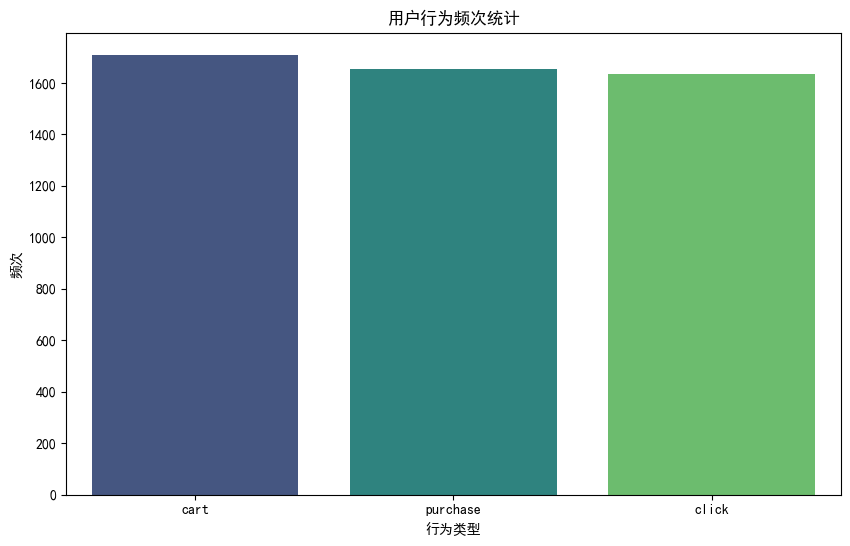

代码运行结果：
   user_id  age  gender                signup_date
0        1   58  Female 2023-10-14 02:17:58.385952
1        2   25    Male 2023-08-23 02:17:58.385952
2        3   19  Female 2023-07-25 02:17:58.385952
3        4   65  Female 2023-07-15 02:17:58.385952
4        5   35  Female 2023-10-27 02:17:58.385952
   item_id  category   price
0        1     Books  116.04
1        2     Books  492.52
2        3     Books  109.54
3        4     Books   15.85
4        5  Clothing  254.79
   user_id  item_id behavior_type                  timestamp
0      774      735      purchase 2024-06-19 02:17:58.449652
1      489      826          cart 2024-06-05 02:17:58.449652
2      307      530      purchase 2024-06-18 02:17:58.449652
3       10      967         click 2024-06-17 02:17:58.449652
4      785       72      purchase 2024-06-20 02:17:58.449652
cart        1710
purchase    1656
click       1634
Name: behavior_type, dtype: int64
代码执行成功



代码运行成功！
增加至最终代码中

====================代码链 - 第3次迭代==

<Figure size 640x480 with 0 Axes>

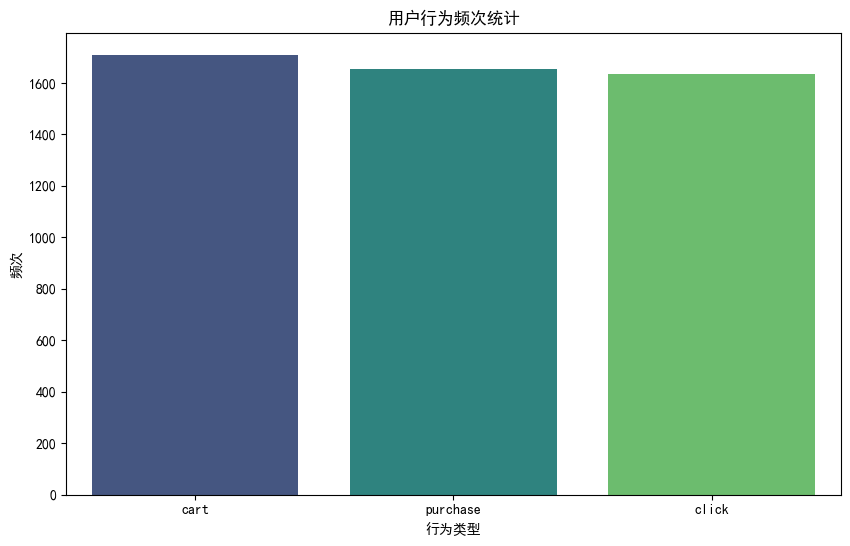

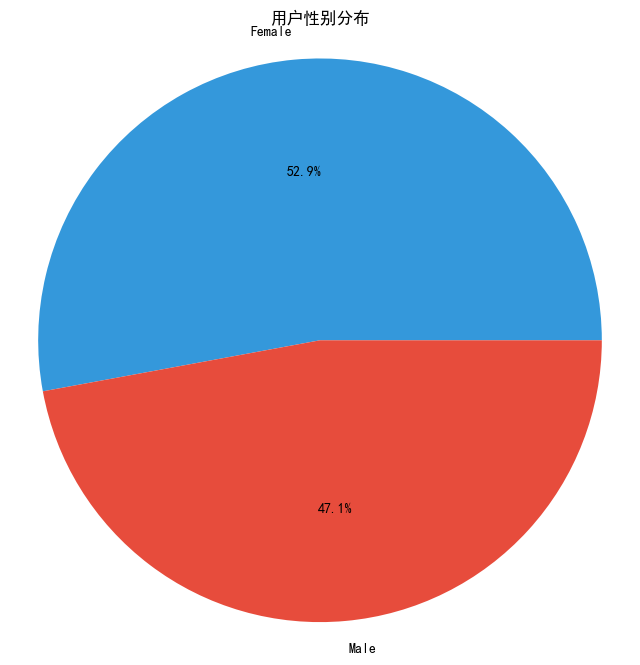

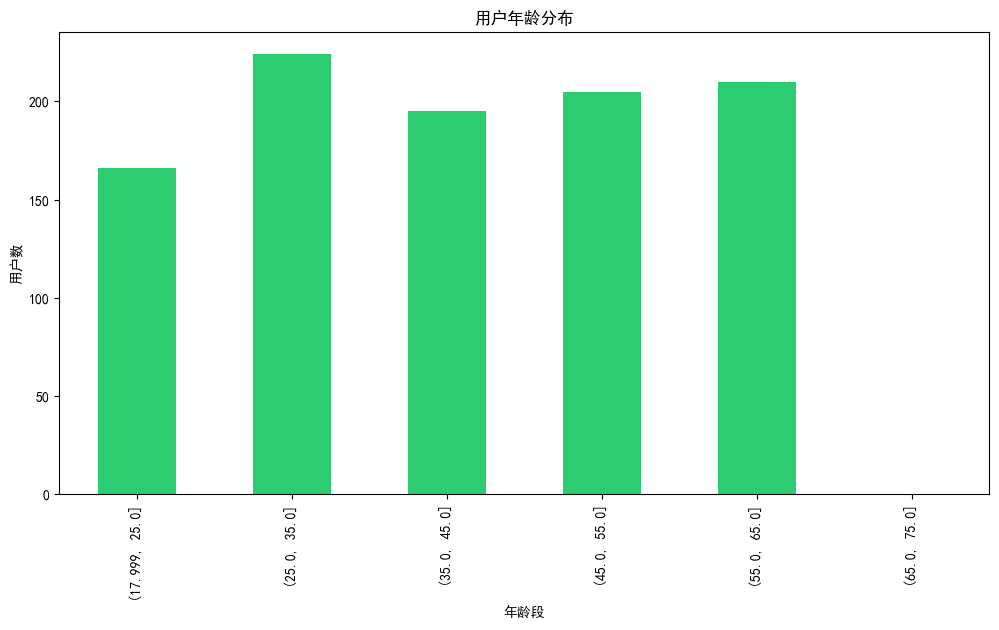

代码运行结果：
   user_id  age  gender                signup_date
0        1   58  Female 2023-10-14 02:18:03.792599
1        2   25    Male 2023-08-23 02:18:03.792599
2        3   19  Female 2023-07-25 02:18:03.792599
3        4   65  Female 2023-07-15 02:18:03.792599
4        5   35  Female 2023-10-27 02:18:03.792599
   item_id  category   price
0        1     Books  116.04
1        2     Books  492.52
2        3     Books  109.54
3        4     Books   15.85
4        5  Clothing  254.79
   user_id  item_id behavior_type                  timestamp
0      774      735      purchase 2024-06-19 02:18:03.854303
1      489      826          cart 2024-06-05 02:18:03.854303
2      307      530      purchase 2024-06-18 02:18:03.854303
3       10      967         click 2024-06-17 02:18:03.854303
4      785       72      purchase 2024-06-20 02:18:03.854303
cart        1710
purchase    1656
click       1634
Name: behavior_type, dtype: int64
性别分布:
 Female    529
Male      471
Name: gender, dtype: int64

<Figure size 640x480 with 0 Axes>

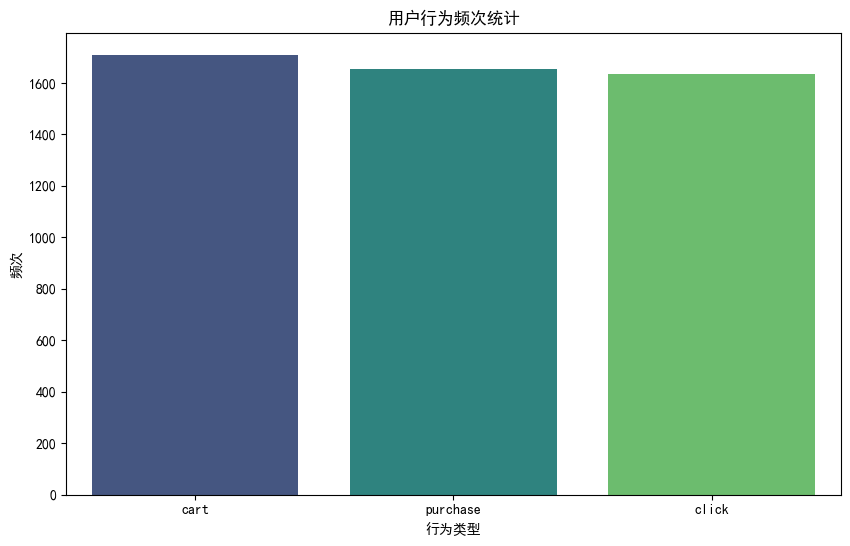

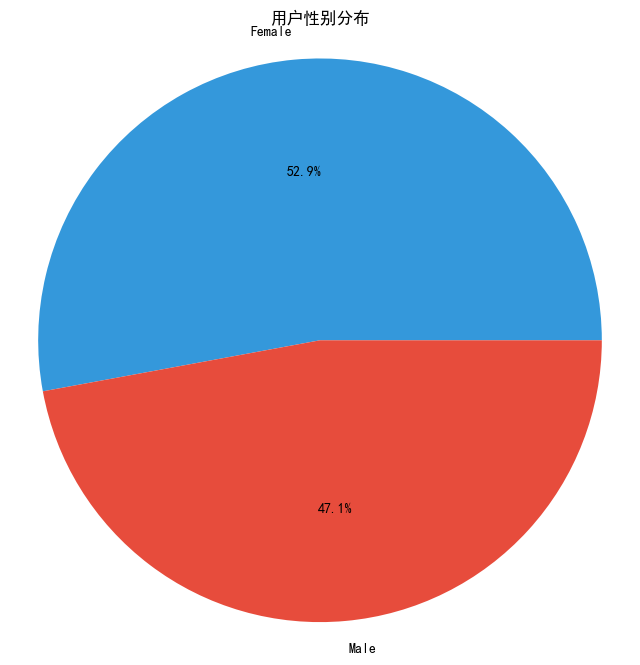

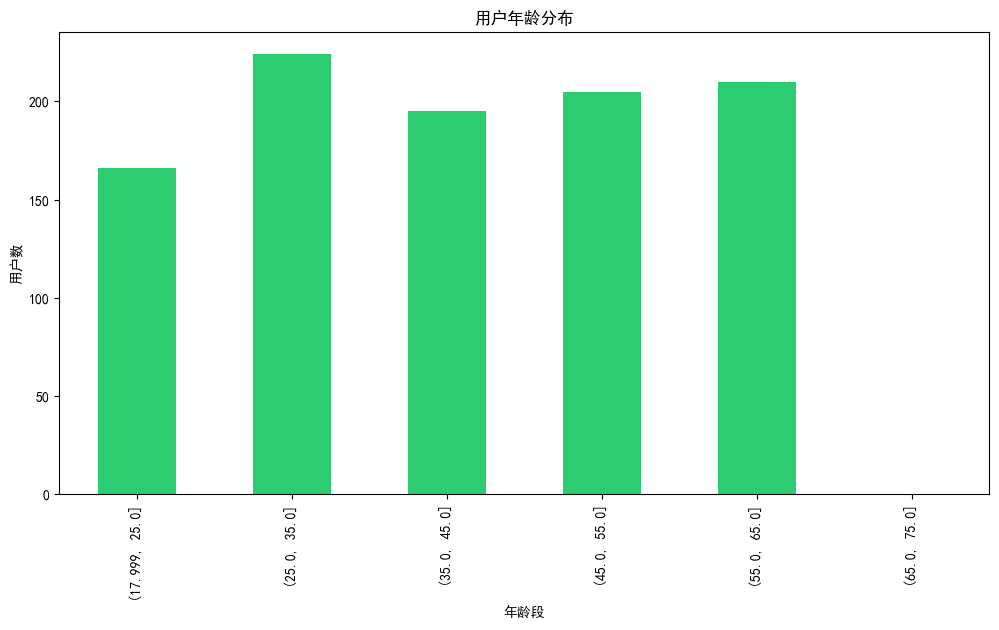

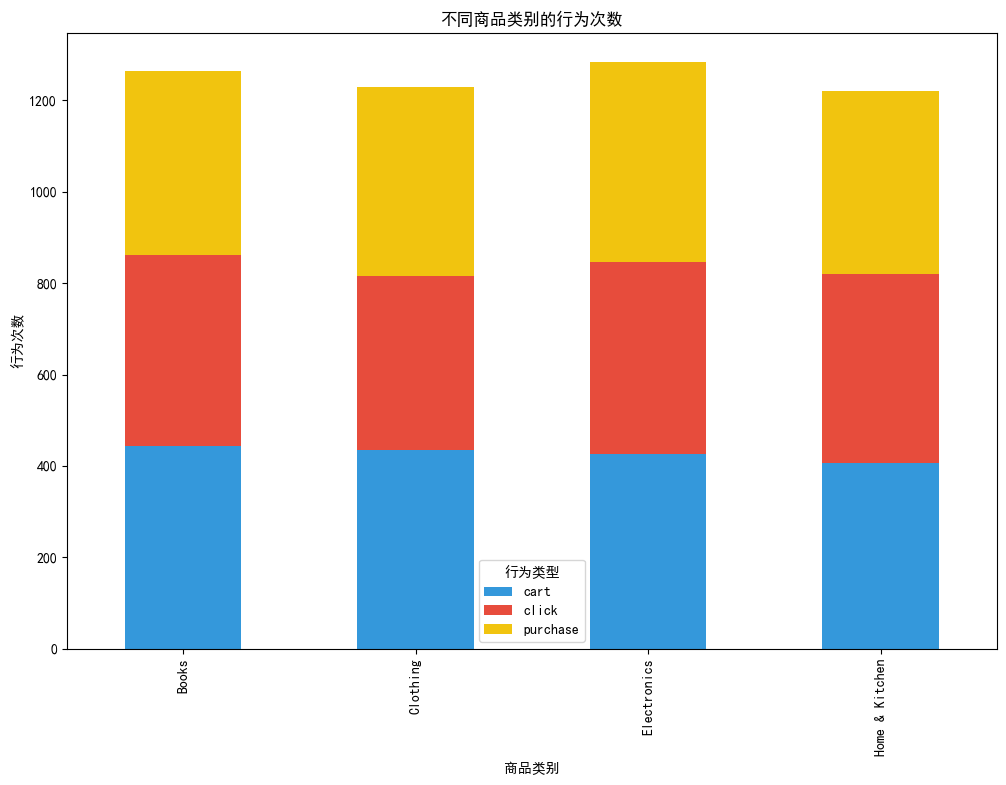

代码运行结果：
   user_id  age  gender                signup_date
0        1   58  Female 2023-10-14 02:18:08.757038
1        2   25    Male 2023-08-23 02:18:08.757038
2        3   19  Female 2023-07-25 02:18:08.757038
3        4   65  Female 2023-07-15 02:18:08.757038
4        5   35  Female 2023-10-27 02:18:08.757038
   item_id  category   price
0        1     Books  116.04
1        2     Books  492.52
2        3     Books  109.54
3        4     Books   15.85
4        5  Clothing  254.79
   user_id  item_id behavior_type                  timestamp
0      774      735      purchase 2024-06-19 02:18:08.821162
1      489      826          cart 2024-06-05 02:18:08.821162
2      307      530      purchase 2024-06-18 02:18:08.821162
3       10      967         click 2024-06-17 02:18:08.821162
4      785       72      purchase 2024-06-20 02:18:08.821162
cart        1710
purchase    1656
click       1634
Name: behavior_type, dtype: int64
性别分布:
 Female    529
Male      471
Name: gender, dtype: int64

<Figure size 640x480 with 0 Axes>

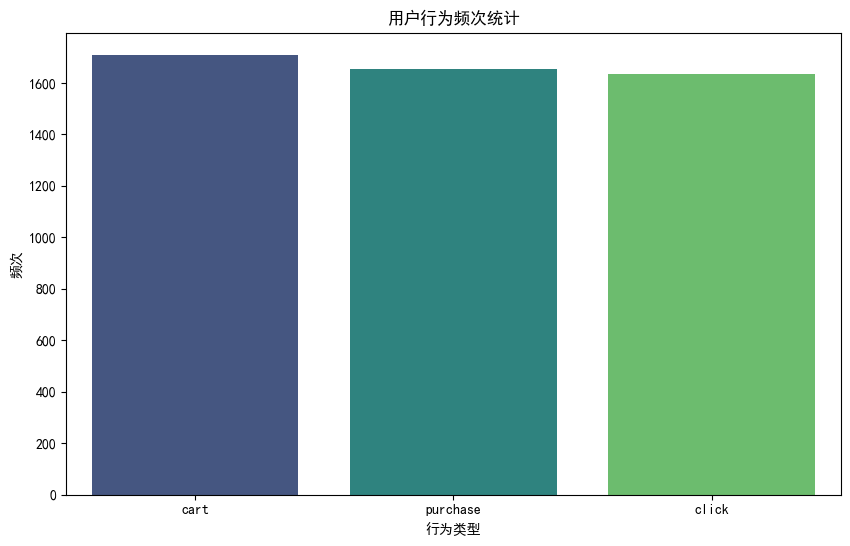

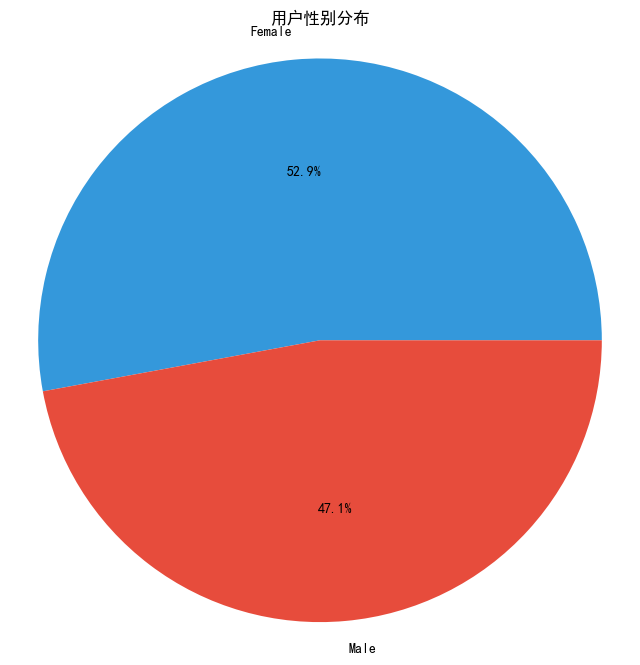

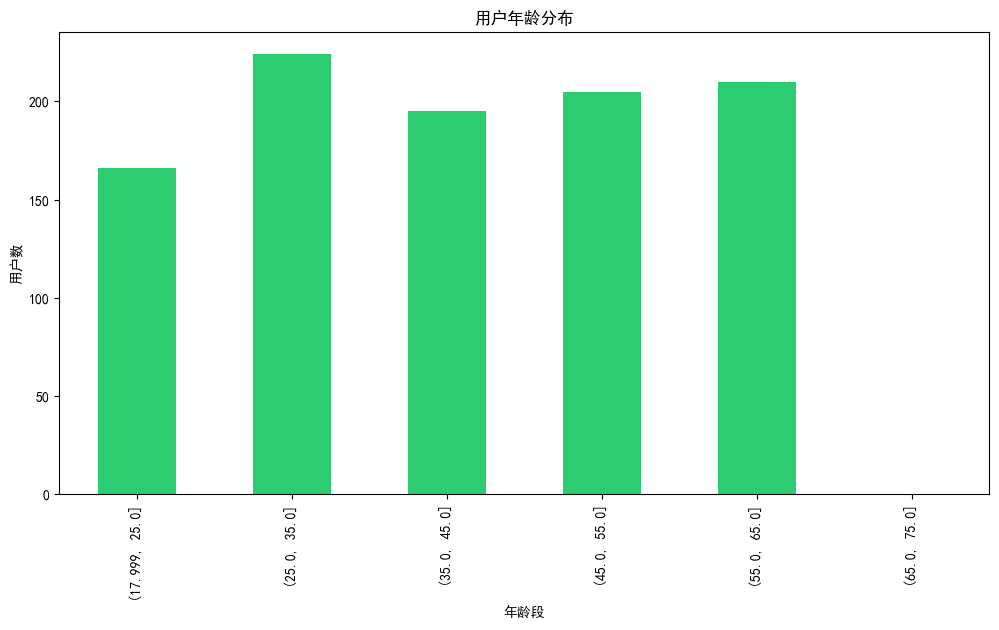

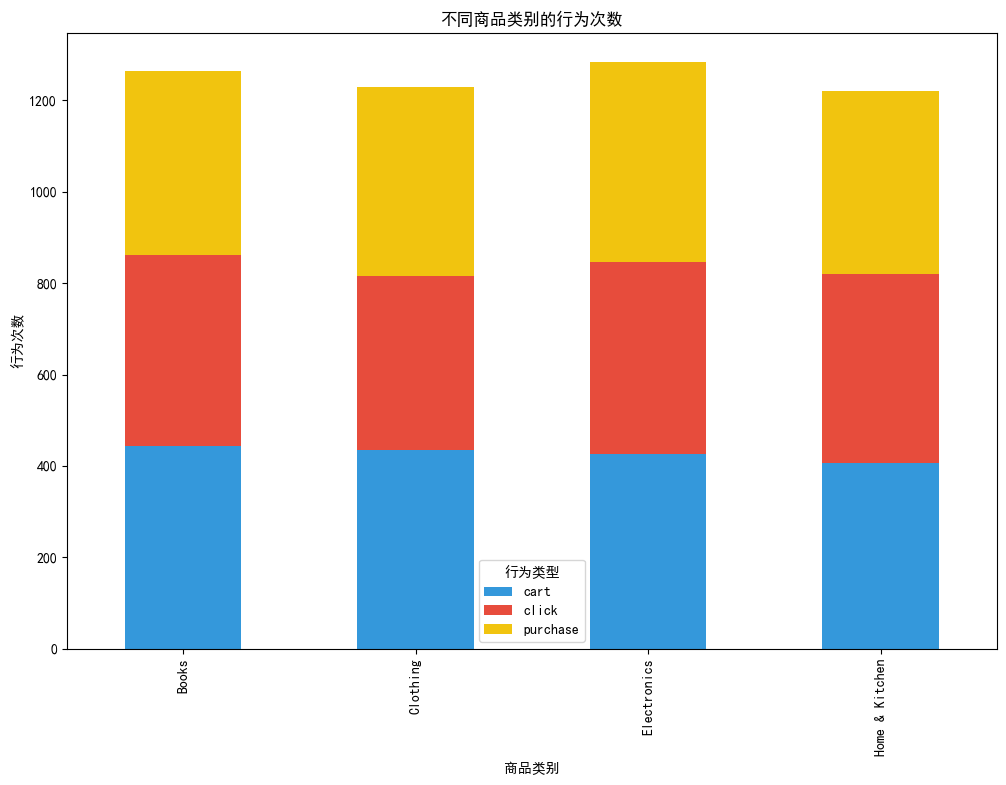

代码运行结果：
   user_id  age  gender                signup_date
0        1   58  Female 2023-10-14 02:18:15.091502
1        2   25    Male 2023-08-23 02:18:15.091502
2        3   19  Female 2023-07-25 02:18:15.091502
3        4   65  Female 2023-07-15 02:18:15.091502
4        5   35  Female 2023-10-27 02:18:15.091502
   item_id  category   price
0        1     Books  116.04
1        2     Books  492.52
2        3     Books  109.54
3        4     Books   15.85
4        5  Clothing  254.79
   user_id  item_id behavior_type                  timestamp
0      774      735      purchase 2024-06-19 02:18:15.154037
1      489      826          cart 2024-06-05 02:18:15.154037
2      307      530      purchase 2024-06-18 02:18:15.154037
3       10      967         click 2024-06-17 02:18:15.154037
4      785       72      purchase 2024-06-20 02:18:15.154037
cart        1710
purchase    1656
click       1634
Name: behavior_type, dtype: int64
性别分布:
 Female    529
Male      471
Name: gender, dtype: int64

<Figure size 640x480 with 0 Axes>

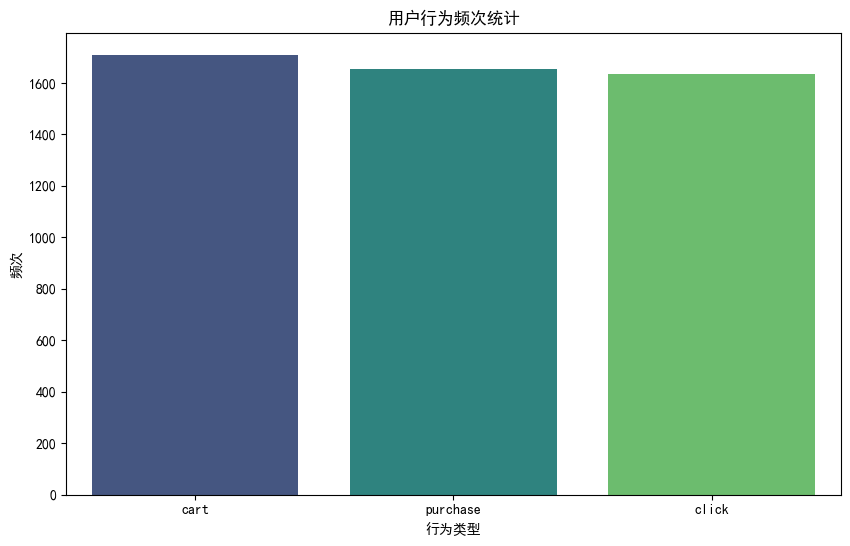

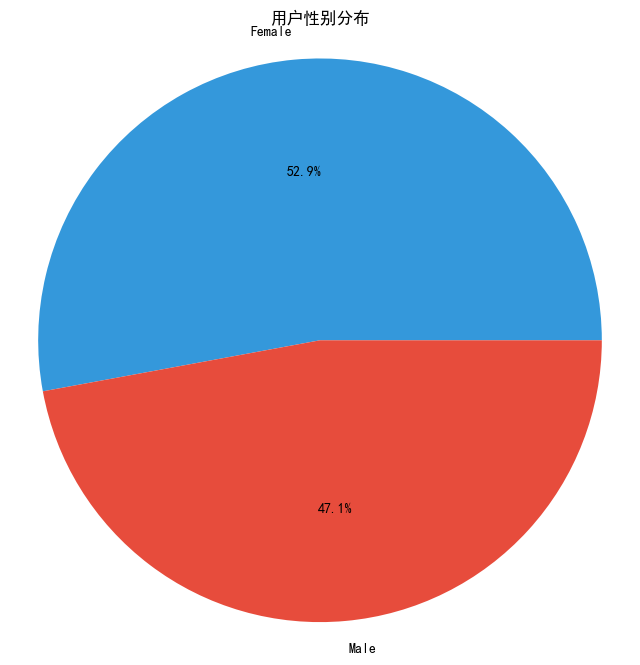

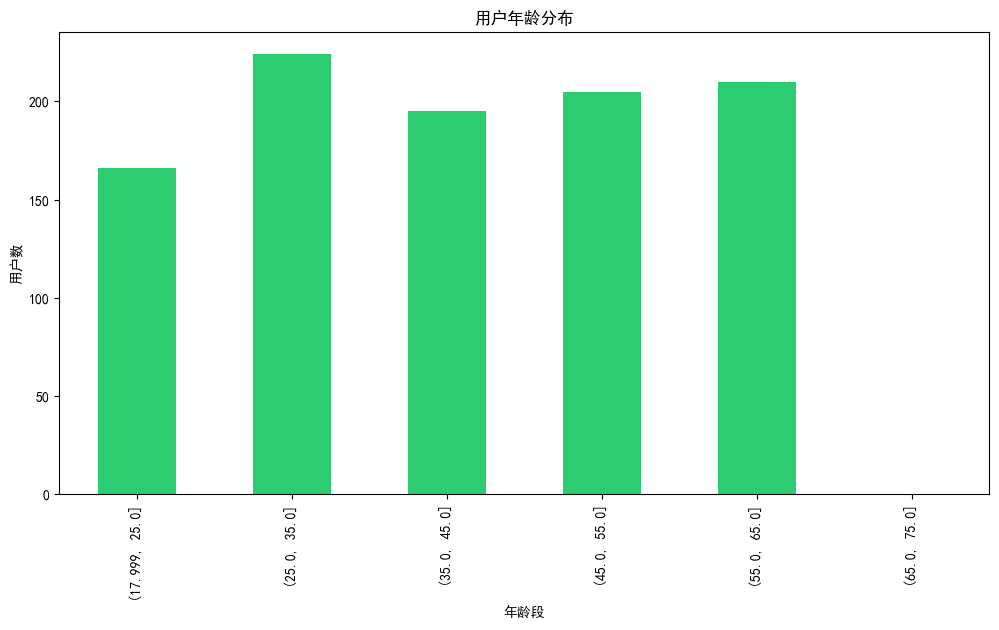

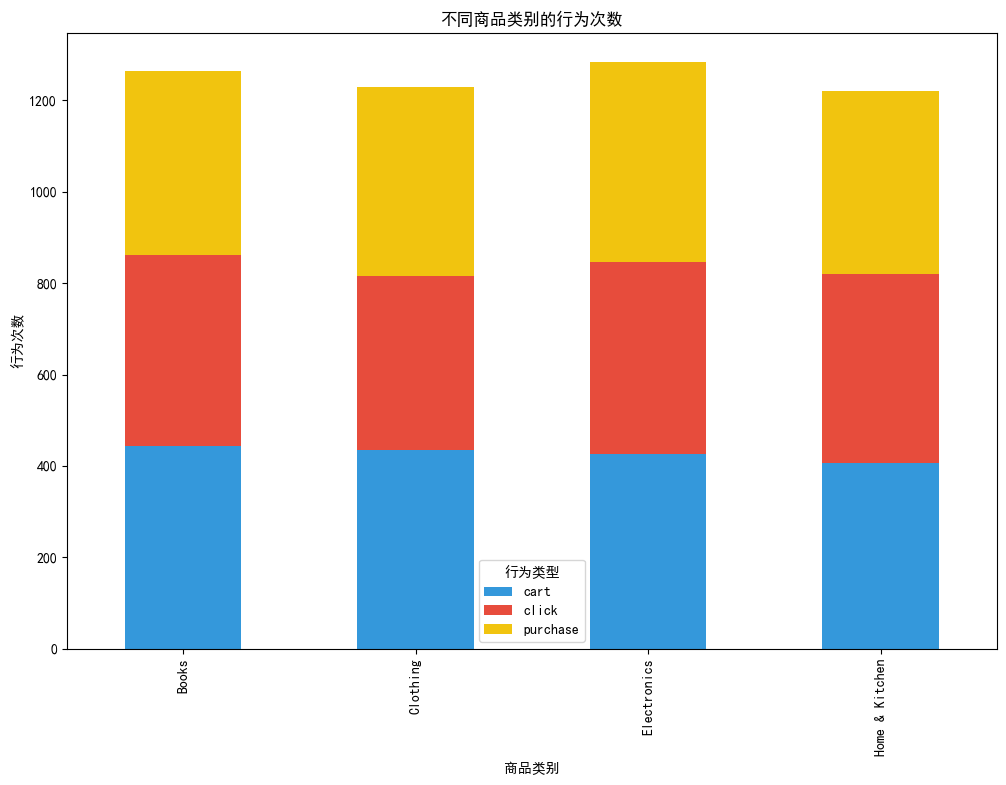

代码运行结果：
   user_id  age  gender                signup_date
0        1   58  Female 2023-10-14 02:18:22.090376
1        2   25    Male 2023-08-23 02:18:22.090376
2        3   19  Female 2023-07-25 02:18:22.090376
3        4   65  Female 2023-07-15 02:18:22.090376
4        5   35  Female 2023-10-27 02:18:22.090376
   item_id  category   price
0        1     Books  116.04
1        2     Books  492.52
2        3     Books  109.54
3        4     Books   15.85
4        5  Clothing  254.79
   user_id  item_id behavior_type                  timestamp
0      774      735      purchase 2024-06-19 02:18:22.255324
1      489      826          cart 2024-06-05 02:18:22.255324
2      307      530      purchase 2024-06-18 02:18:22.255324
3       10      967         click 2024-06-17 02:18:22.255324
4      785       72      purchase 2024-06-20 02:18:22.255324
cart        1710
purchase    1656
click       1634
Name: behavior_type, dtype: int64
性别分布:
 Female    529
Male      471
Name: gender, dtype: int64

'# Part 6: 总结与反思\n\n```python\n# 总结\n# 虚拟用户数据和商品数据生成成功，包括用户的年龄、性别和注册日期等信息，以及商品的类别和价格信息。\n# 用户行为数据通过随机生成用户行为类型和时间戳来模拟，创建了一个较为全面的数据集。\n\n# 数据分析\n# - 用户行为频次统计清楚地展示了不同行为类型的频次。\n# - 用户画像分析通过性别分布饼图和年龄分布柱状图展示了用户的基本信息。\n# - 用户行为与商品类别的关系通过堆叠柱状图展示了不同行为类型在不同商品类别中的比例。\n\n# 预测\n# 使用随机森林分类器简单地对用户行为进行了预测，虽然准确率仅为35.1%，但展示了如何使用机器学习模型进行用户行为预测。\n\n# 反思\n# 虚拟数据可以更复杂和多样化，以更好地模拟真实世界的数据场景。\n# 预测模型的表现较差，这可能是因为仅使用了简单的特征（用户ID、商品ID和价格），可以通过加入更多的特征来提高准确率。\n# 数据分析可以进一步细化，分析不同用户群体的行为习惯，以及不同商品类别的销售趋势等。\n```\n\n[END]'

In [5]:
model = "gpt-3.5-turbo"
model = "deepseek-coder"
model = "claude-3-haiku"
model = "gpt-4o"

coding_expert = CodingExpert(model=model)

question = "帮我构建一个虚拟的股票收盘价数据，训练一个简单的DNN模型，预测未来5日的涨跌。"
question = "帮我构建一个虚拟电商类，进行简单的数据分析和走势图绘制。"
question = '''
创建一个电商网站的用户行为分析案例,包括用户行为数据的获取、数据分析、用户行为预测等。

# 要求
- 需要创建一系列复杂的虚拟数据,包括用户行为数据、商品数据等
- 需要使用多种数据分析方法,包括用户行为分析、用户画像分析等
- 需要使用数据可视化方法,展示数据分析结果
'''

coding_expert.expert_coding(question)

In [1]:
from IPython.display import clear_output
import time

for i in range(10):
    clear_output(wait=True)
    print(f"Iteration {i}")
    # 可以在这里绘制图片或进行其他操作
    time.sleep(1)  # 仅用于演示


Iteration 9


当构建一个虚拟电商类时，我们需要考虑以下问题：
1. 电商类需要包括哪些属性和方法？
2. 如何生成虚拟的电商数据？
3. 如何进行简单的数据分析？
4. 如何绘制走势图？

接下来，我将逐步回答这些问题并提供相应的Python代码。

### 1. 构建电商类
首先，我们需要定义一个`Ecommerce`类，包括属性和方法：
- 属性：订单信息、销售额、用户数量等
- 方法：添加订单、计算销售总额、统计用户数量等

```python
class Ecommerce:
    def __init__(self):
        self.orders = []  # 存储订单信息
        self.total_sales = 0  # 销售总额
        self.total_users = 0  # 用户总数
        
    def add_order(self, order):
        self.orders.append(order)
        self.total_sales += order['amount']  # 假设订单信息中有金额字段
        self.total_users += 1  # 假设每个订单对应一个用户
    
    def calculate_total_sales(self):
        return self.total_sales
    
    def count_total_users(self):
        return self.total_users
```

### 2. 生成虚拟的电商数据
为了演示，我们生成一些虚拟的订单数据。假设每个订单包括订单号、金额和用户ID：

```python
import random

def generate_order():
    order_id = random.randint(1000, 9999)
    amount = random.randint(100, 1000)
    user_id = random.randint(1, 100)
    return {'order_id': order_id, 'amount': amount, 'user_id': user_id}

# 生

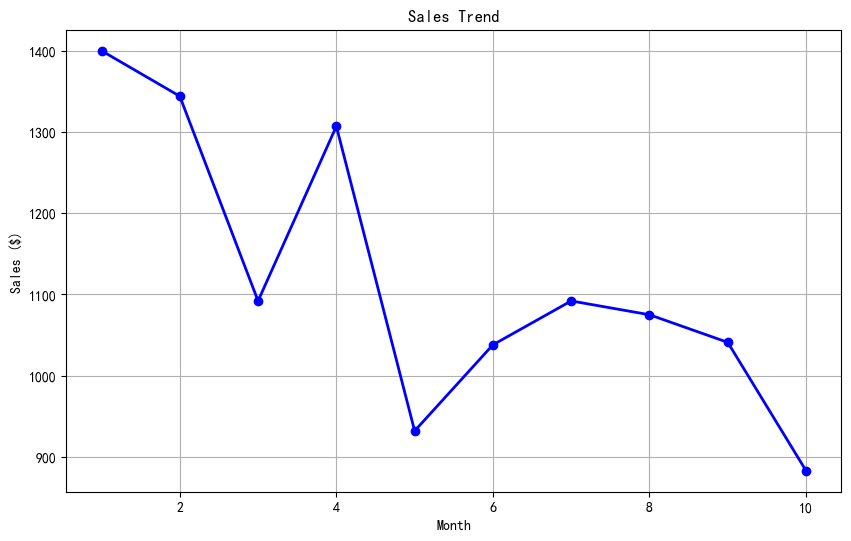

代码运行结果：
Total Sales: $5704
Total Users: 10
代码执行成功



代码运行成功！
增加至最终代码中


'Total Sales: $5704\nTotal Users: 10\n代码执行成功\n'

In [8]:
question = "帮我构建一个虚拟电商类，进行简单的数据分析和走势图绘制。"
model = "gpt-3.5-turbo"
coding_expert = CodingExpert(model=model)
coding_expert.direct_coding(question)